In [1]:
from os.path import join
import numpy as np
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pysal
plt.rcParams.update({'font.size': 22})
from scipy.stats import kurtosis, skew
from shapely.geometry import box, Polygon
from IPython.display import IFrame

from data_utils import *

# display map html when it's working again
#IFrame(src="../beira/idai_final.html", width = 800, height=500)

# Exploratory data analysis

In [2]:
save_dir = join("..", "beira", "outdata")
feature_gdf = gpd.read_file(join("..", "beira", "outdata", "feature_stats.shp"))

# check projection and re-project to ESPG:4326 (lon/lat)
print("crs: ", feature_gdf.crs)
feature_gdf = feature_gdf.to_crs("EPSG:3857")
print("features: " , *feature_gdf.columns)
print("area of a grid square: ", np.round(feature_gdf["geometry"].area.mean(), 4), "m")
print("features:", *feature_gdf.columns)

# re-project back to EPSG:4326
feature_gdf = feature_gdf.to_crs("EPSG:4326")

crs:  epsg:4326
features:  elevation aspect curvature slope soilcarbon mangroves ndvi_mfmas evi_mfmask jrc_permwa precipitat floodfrac dist_pw slope_pw geometry
area of a grid square:  1000000.0 m
features: elevation aspect curvature slope soilcarbon mangroves ndvi_mfmas evi_mfmask jrc_permwa precipitat floodfrac dist_pw slope_pw geometry


# Comparison to Muckley (2020) data

If I want to crop to the same area as Muckley (2020) uses in Mozambique, I need to convert the projections first. From [here](https://github.com/leomuckley/Multi-Input-ConvLSTM/tree/master/utils) I know the area of interest is:

    moz_aoi = ee.Geometry.Rectangle([ 33.69213642, -20.57556134,  35.30819006, -18.97632074])
    
These look like lon/lat projections so need to use `EPSG:4362`.
Then visualise both to check that they overlap okay and clip.

Muckley (2020) area: 34035296693.890228
My area: 1805999999.999961


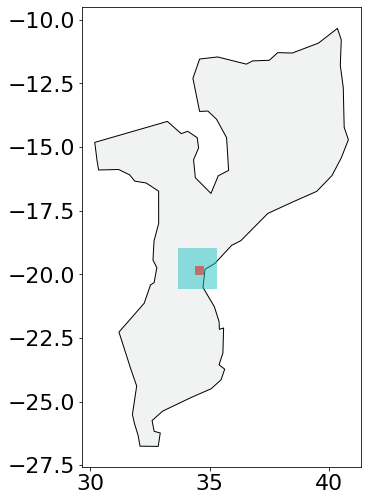

In [3]:
# boundary boxes for areas of interest
my_boundary = box(*feature_gdf.total_bounds)
my_boundary = gpd.GeoSeries(my_boundary).set_crs("EPSG:4326")

muckley_boundary = box(33.69213642, -20.57556134,  35.30819006, -18.97632074)
muckley_boundary = gpd.GeoSeries(muckley_boundary).set_crs("EPSG:4326")

# visualise on a mamp of Mozambique
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mozambique = world.loc[world['name'] == 'Mozambique']['geometry']

fig, ax = plt.subplots(figsize=(5,10))
mozambique.plot(ax=ax, color='#f1f2f2', edgecolor='black')
muckley_boundary.plot(ax=ax, color='#21c4c5', alpha=0.5)
my_boundary.plot(ax=ax, color='red', alpha=0.5)

muckley_area = muckley_boundary.to_crs("EPSG:3857").area[0]
my_area = my_boundary.to_crs("EPSG:3857").area[0]
print("Muckley (2020) area:", '{:f}'.format(muckley_area))
print("My area:", '{:f}'.format(my_area))

So Muckley (2020) uses a much bigger spatial extent. Yet for Mozambique the paper states a count of 32200 or 32039 features are used (and I get 25920 when I run the code here) while I have 1369544 features. Muckley also uses 1sqkm squares with spatial grid staggering, so should have far more entries than me. It's a little odd that I have so many more inputs, let's compare the grids...

In [4]:
floodfrac = feature_gdf.floodfrac
print("Summary statistics:\n-------------------")
print("count flood fraction:", len(floodfrac))
print("mean flood fraction:", np.round(np.mean(floodfrac), 4))
print("median flood fraction:", np.round(np.median(floodfrac), 4))

vals, counts = np.unique(floodfrac, return_counts=True)
index = np.argmax(counts)
print("mode flood fraction:", np.round(vals[index], 4))
print("std flood fraction:", np.round(np.std(floodfrac), 4))
print("kurtosis flood fraction:", np.round(kurtosis(floodfrac), 4))
print("skew flood fraction:", np.round(skew(floodfrac), 4))

Summary statistics:
-------------------
count flood fraction: 1806
mean flood fraction: 0.3376
median flood fraction: 0.2312
mode flood fraction: 0.0
std flood fraction: 0.347
kurtosis flood fraction: -1.2463
skew flood fraction: 0.526


Negative kurtosis means that the data seems to have fewer extreme values than a normal distribution would, these distributions often appear flat-toppped. The skew is low, and as is shown below, the flooding distribution appears almost uniform when you ignore the mode value 0, which aligns with the negative kurtosis value.

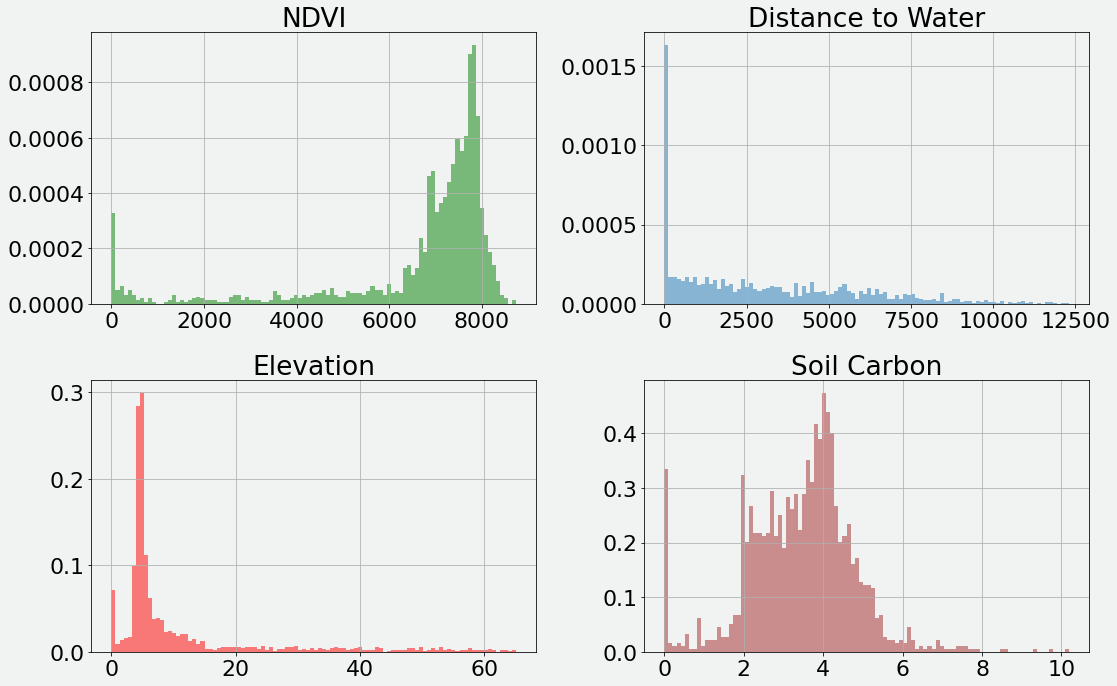

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), facecolor='#f1f2f2', tight_layout=True)

for i in range(2):
    for j in range(2):
        axs[i, j].set_facecolor("#f1f2f2")
        axs[i, j].grid()

axs[0, 0].hist(feature_gdf.ndvi_mfmas, bins=100, alpha=0.5, density=True, color="green");
axs[0, 1].hist(feature_gdf.dist_pw, bins=100, alpha=0.5, density=True);
axs[1, 0].hist(feature_gdf.elevation, bins=100, alpha=0.5, density=True, color="red");
axs[1, 1].hist(feature_gdf.soilcarbon, bins=100, alpha=0.5, density=True, color="brown");

axs[0, 0].set_title("NDVI")
axs[0, 1].set_title("Distance to Water")
axs[1, 0].set_title("Elevation")
axs[1, 1].set_title("Soil Carbon");

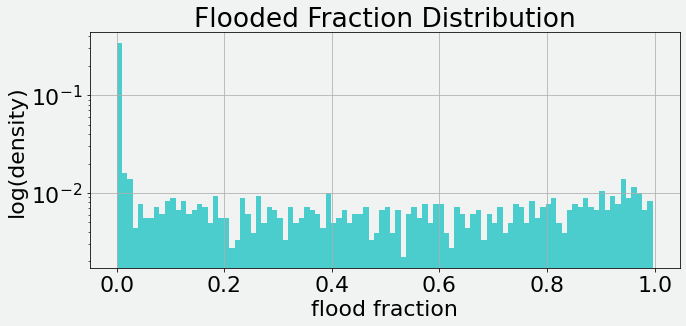

In [6]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='#f1f2f2', tight_layout=True)
ax.grid(zorder=1)

floodfrac = [*feature_gdf.floodfrac]
weights = np.ones_like(floodfrac)/float(len(floodfrac))
ax.hist(floodfrac, bins=100, weights=weights, alpha=0.8, density=False, log=True, color="#21c4c5");
ax.set_ylabel("log(density)");
ax.set_xlabel("flood fraction");
ax.set_title("Flooded Fraction Distribution");
ax.set_facecolor("#f1f2f2")

The data is not that highly-skewed (skewness=0.4591 and kurtosis=-1.3076).

## Spatial autocorrelation
Maybe start with [this](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html) blog post about global spatial autocorrelation.

Need to recalculate the standard deviations and lags for this.

In [7]:
from pysal.lib import weights
from pysal.explore import esda

/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [8]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(feature_gdf, k=8)
# Row-standardization
w.transform = 'R'

feature_gdf['floodfrac_lag'] = weights.spatial_lag.lag_spatial(w, feature_gdf['floodfrac'])
feature_gdf['floodfrac_std'] = ( feature_gdf['floodfrac'] - feature_gdf['floodfrac'].mean() )
feature_gdf['floodfrac_lag_std'] = ( feature_gdf['floodfrac_lag'] - feature_gdf['floodfrac_lag'].mean() )

Moran's I-value for flood fraction: 0.84
p-value: 0.001


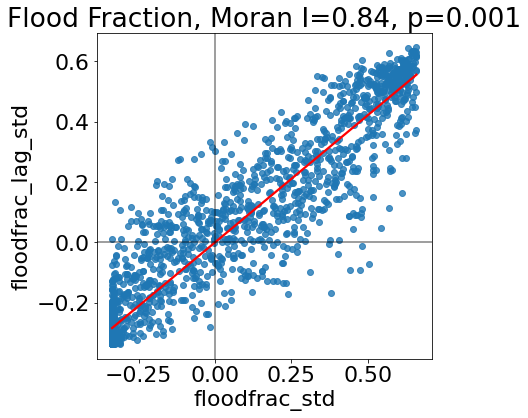

In [9]:
moran = esda.moran.Moran(feature_gdf['floodfrac'], w)
moranI = np.round(moran.I, 2)
print(f"Moran's I-value for flood fraction: {moranI}")
print(f"p-value: {moran.p_sim}")

# now to create a Moran plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x='floodfrac_std',
    y='floodfrac_lag_std', 
    ci=None,
    data=feature_gdf,
    line_kws={'color':'r'},
    
)
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title(f'Flood Fraction, Moran I={moranI}, p={moran.p_sim}')
plt.show()

There is a similar level of spatial autocorrelation to what Muckley (2020) found. This justifies our use of a convolutional layer.

In [30]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
feature_gdf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
elevation,1763.00,10.76,13.25,0.00,4.29,5.09,10.08,65.16
aspect,1763.00,169.06,42.41,46.47,140.42,168.29,193.30,270.08
curvature,1763.00,36690.66,19196691.55,-140818481.34,-3884918.45,-182902.76,2727872.22,185327995.22
slope,1763.00,763.47,832.41,0.00,90.98,364.01,1312.09,4768.96
soilcarbon,1763.00,3.45,1.34,0.00,2.62,3.60,4.22,10.19
mangroves,1806.00,0.02,0.06,0.00,0.00,0.00,0.00,0.62
ndvi_mfmas,1788.00,6632.42,1996.75,0.00,6710.75,7363.10,7759.78,8739.94
evi_mfmask,1771.00,5098.27,1827.81,0.00,4595.68,5639.95,6327.95,8105.20
jrc_permwa,1806.00,6.21,19.75,0.00,0.00,0.00,0.06,99.10
precipitat,1763.00,0.01,0.00,0.01,0.01,0.01,0.01,0.02


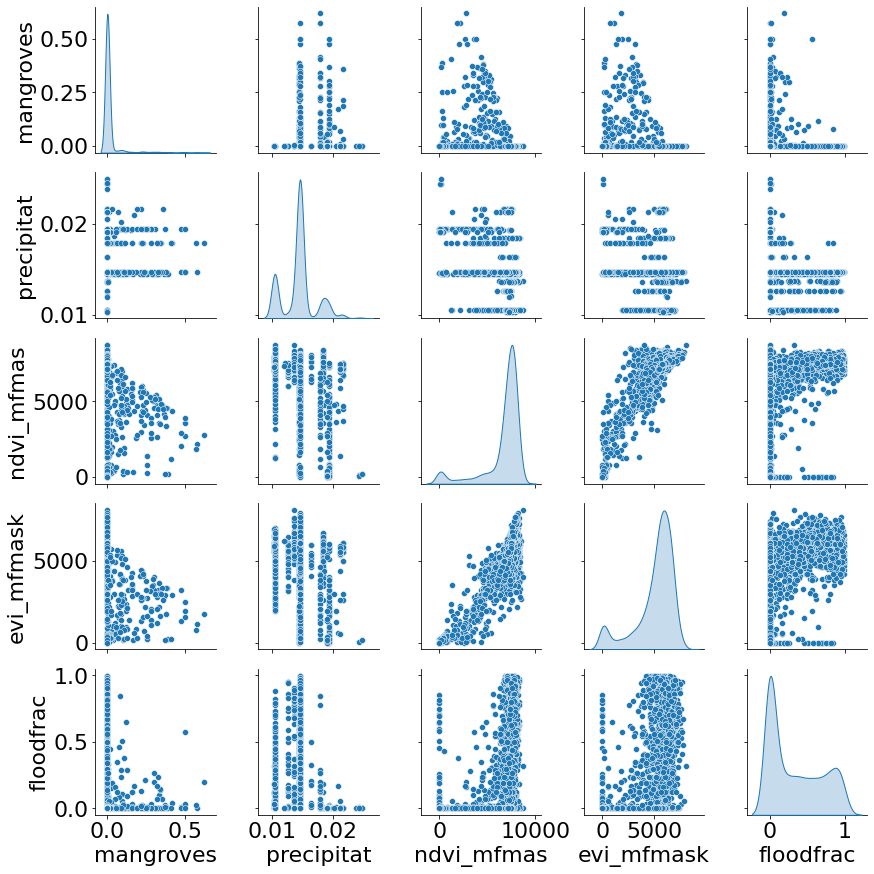

In [19]:
sns.pairplot(feature_gdf[['mangroves', 'precipitat', 'ndvi_mfmas', 'evi_mfmask', 'floodfrac']], diag_kind='kde');

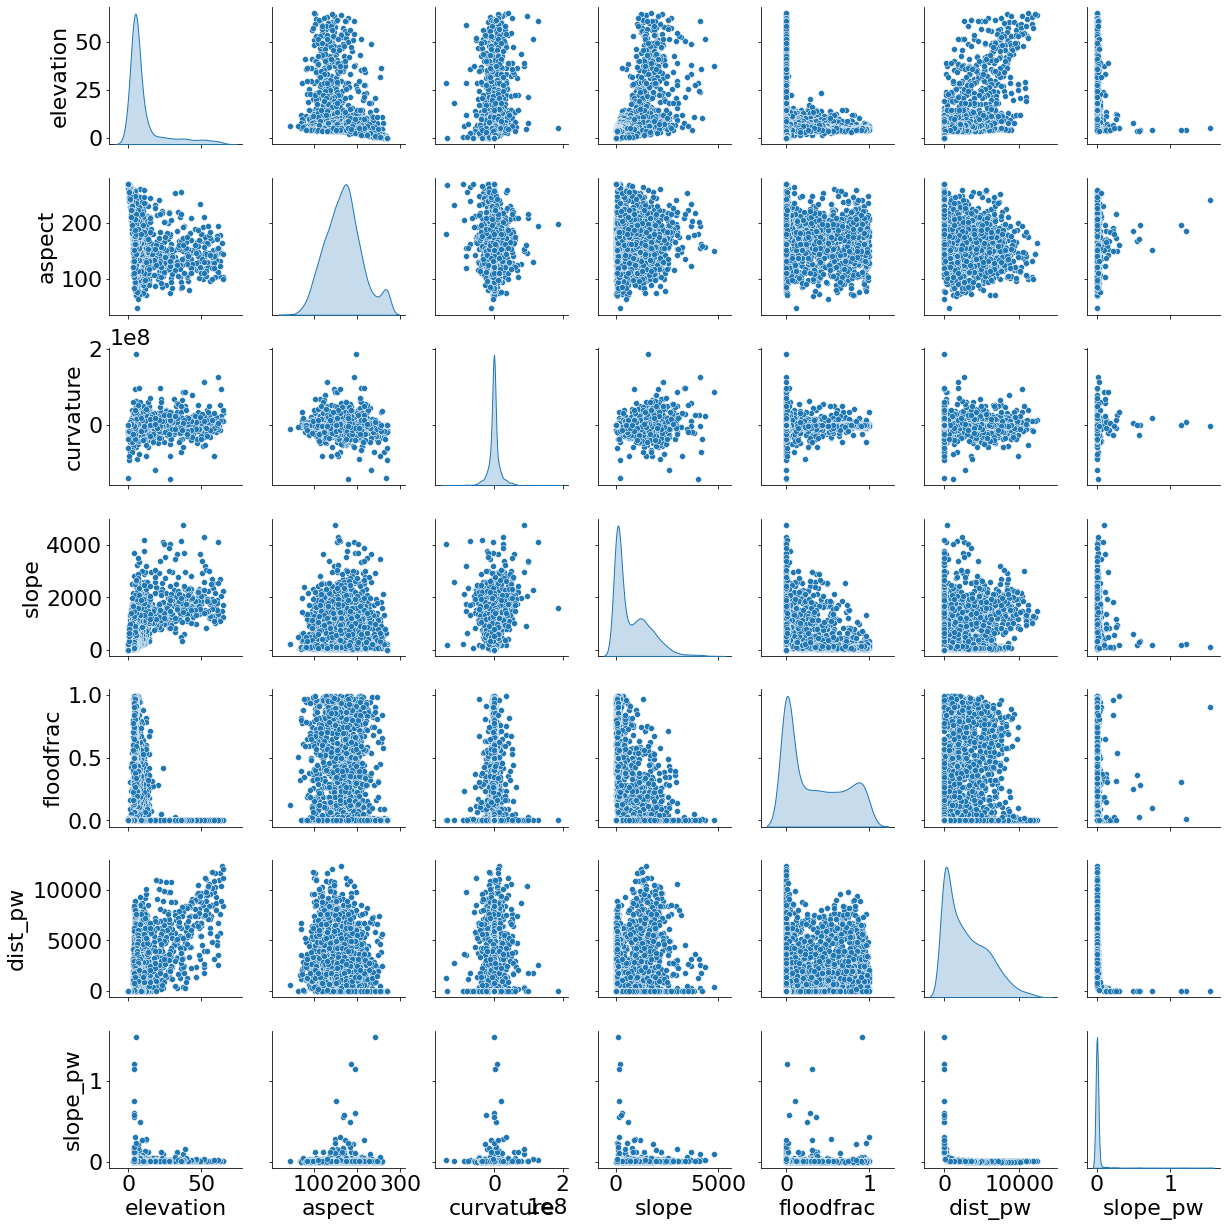

In [23]:
sns.pairplot(feature_gdf[['elevation', 'aspect', 'curvature', 'slope', 'floodfrac', 'dist_pw', 'slope_pw']], diag_kind='kde');

In [24]:
# use later



,count,mean,std,min,25%,50%,75%,max
elevation,1763.0,1.076196e+01,1.325003e+01,0.000000e+00,4.287047e+00,5.093667,1.008213e+01,6.516211e+01
aspect,1763.0,1.690595e+02,4.240838e+01,4.646530e+01,1.404151e+02,168.285193,1.933037e+02,2.700808e+02
curvature,1763.0,3.669066e+04,1.919669e+07,-1.408185e+08,-3.884918e+06,-182902.760225,2.727872e+06,1.853280e+08
slope,1763.0,7.634669e+02,8.324055e+02,0.000000e+00,9.098010e+01,364.014661,1.312091e+03,4.768959e+03
soilcarbon,1763.0,3.447486e+00,1.340900e+00,0.000000e+00,2.623138e+00,3.599574,4.222819e+00,1.019295e+01
mangroves,1806.0,1.569750e-02,6.423300e-02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,6.171277e-01
ndvi_mfmas,1788.0,6.632425e+03,1.996746e+03,0.000000e+00,6.710752e+03,7363.100706,7.759785e+03,8.739939e+03
evi_mfmask,1771.0,5.098268e+03,1.827806e+03,0.000000e+00,4.595685e+03,5639.948085,6.327953e+03,8.105197e+03
jrc_permwa,1806.0,6.207115e+00,1.975336e+01,0.000000e+00,0.000000e+00,0.000957,5.752660e-02,9.909926e+01
precipitat,1763.0,1.443278e-02,2.608994e-03,1.034201e-02,1.445232e-02,0.014668,1.466803e-02,2.491356e-02
